In [1]:
import pandas as pd
import numpy as np
import pymc

%matplotlib inline
import os
import math
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image, HTML
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df_16=pd.read_csv("C:\\Users\\Yannick\\Documents\\CoursENSAE\\Statapp\\F1_1617.csv")
df_15=pd.read_csv("C:\\Users\\Yannick\\Documents\\CoursENSAE\\Statapp\\F1_1516.csv")
df_14=pd.read_csv("C:\\Users\\Yannick\\Documents\\CoursENSAE\\Statapp\\F1_1415.csv")
df_13=pd.read_csv("C:\\Users\\Yannick\\Documents\\CoursENSAE\\Statapp\\F1_1314.csv")
df_12=pd.read_csv("C:\\Users\\Yannick\\Documents\\CoursENSAE\\Statapp\\F1_1213.csv")

df_15=df_15.drop(380)
df=df_15
df.head(5)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,F1,07/08/15,Lille,Paris SG,0.0,1.0,A,0.0,0.0,D,...,1.63,25.0,0.75,2.11,2.03,1.85,1.80,7.58,3.91,1.58
1,F1,08/08/15,Bastia,Rennes,2.0,1.0,H,0.0,1.0,A,...,1.50,27.0,0.00,1.87,1.80,2.10,2.03,2.81,2.93,3.10
2,F1,08/08/15,Marseille,Caen,0.0,1.0,A,0.0,1.0,A,...,2.15,31.0,-1.00,2.00,1.92,1.95,1.90,1.57,4.13,7.04
3,F1,08/08/15,Montpellier,Angers,0.0,2.0,A,0.0,1.0,A,...,1.54,26.0,-0.50,1.84,1.78,2.13,2.06,1.84,3.42,5.42
4,F1,08/08/15,Nantes,Guingamp,1.0,0.0,H,0.0,0.0,D,...,1.44,25.0,-0.25,1.87,1.82,2.10,2.01,2.37,3.01,3.76


In [3]:
 def clean_df(df_input):
    df = df_input.rename(columns={'HomeTeam':'home','AwayTeam':'away','FTHG': 'home_score', 'FTAG': 'away_score','FTR':'outcome'})
    df=df[['home','away','home_score', 'away_score','outcome']]

    teams = df.home.unique()
    teams = pd.DataFrame(teams, columns=['team'])
    teams['i'] = teams.index

    df = pd.merge(df, teams, left_on='home', right_on='team', how='left')
    df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
    df = pd.merge(df, teams, left_on='away', right_on='team', how='left')
    df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)
    df['t']=[int(i/10)+1 for i in df.index]
    return df

In [4]:
a=True
not a

False

In [53]:
def simulate(df_input,clean=False, journee=39):
    if not clean:
        df=clean_df(df_input)
    else:
        df=df_input

    df_train=df[df.t<journee]        

    if journee<=max(df.t):
        df_test=df[df.t==journee]
    else: 
        print("Warning! journee > journee max. Par default, on prend la journée max")
        df_test=df[df.t==journee]
        
    observed_home_goals = df_train.home_score.values
    observed_away_goals = df_train.away_score.values
    home_team = df_train.i_home.values
    away_team = df_train.i_away.values

    home_team_pred = df_test.i_home.values
    away_team_pred = df_test.i_away.values
    

    num_teams = (df_train.i_home.nunique())
    num_games = len(home_team)   


    g = df_train.groupby('i_away')
    alpha_starting_points = (g.away_score.mean())+0.001  #requires non null values
    g = df_train.groupby('i_home')
    beta_starting_points = (g.away_score.mean())+0.001 #requires non null values

    #hyperpriors
    A = pymc.Lognormal('A', 1, 1, value=1)

    mu_alpha=pymc.Normal('mu_alpha', 0, 0.001,value=10)
    mu_beta=pymc.Normal('mu_beta', 0, 0.001,value=10)
    tau_alpha = pymc.Gamma('tau_alpha', 1, 1, value=10)
    tau_beta = pymc.Gamma('tau_beta', 1,1, value=10)

    #team-specific parameters
    alphas_star = pymc.Lognormal("alphas_star", 
                            mu=mu_alpha, 
                            tau=tau_alpha, 
                            size=num_teams, 
                            value=alpha_starting_points.values)
    betas_star = pymc.Lognormal("betas_star", 
                            mu=mu_beta, 
                            tau=tau_beta, 
                            size=num_teams, 
                            value=beta_starting_points.values) 

    # trick to code the sum to zero contraint
    @pymc.deterministic
    def alphas(alphas_star=alphas_star):
        alphas = alphas_star.copy()
        alphas = alphas / np.sum(alphas_star) * num_teams
        return alphas

    @pymc.deterministic
    def betas(betas_star=betas_star):
        betas = betas_star.copy()
        #betas = betas / np.sum(betas_star) * num_teams
        return betas

    @pymc.deterministic
    def home_theta(home_team=home_team, 
                   away_team=away_team, 
                   A=A, 
                   alphas=alphas,
                   betas=betas, 
                   ): 
        return (A *   alphas[home_team] * 
                      betas[away_team])

    @pymc.deterministic
    def away_theta(home_team=home_team, 
                   away_team=away_team, 
                   A=A, 
                   alphas=alphas, 
                   betas=betas, 
                   ): 
        return ( alphas[away_team] *  
                      betas[home_team])   

    @pymc.deterministic
    def home_theta_pred(home_team=home_team_pred, 
                   away_team=away_team_pred, 
                   A=A, 
                   alphas=alphas,
                   betas=betas, 
                   ): 
        return (A *   alphas[home_team] * 
                      betas[away_team])

    @pymc.deterministic
    def away_theta_pred(home_team=home_team_pred, 
                   away_team=away_team_pred, 
                   A=A, 
                   alphas=alphas, 
                   betas=betas, 
                   ): 
        return ( alphas[away_team] *  
                      betas[home_team]) 

    home_goals = pymc.Poisson('home_goals', 
                              mu=home_theta, 
                              value=observed_home_goals, 
                              observed=True)
    away_goals = pymc.Poisson('away_goals', 
                              mu=away_theta, 
                              value=observed_away_goals, 
                              observed=True)


    mcmc = pymc.MCMC([A,
                      mu_alpha,mu_beta, tau_alpha,tau_beta,
                      home_theta, away_theta, 
                      home_theta_pred, away_theta_pred,
                      alphas_star, betas_star, alphas, betas, 
                      home_goals, away_goals])
    map_ = pymc.MAP( mcmc )
    map_.fit()
    mcmc.sample(200000, burn= 5000, thin = 200) 
    # 200 000 iterations
    # sampling starts at 40 000 iterations
    # we tally (pointe) one point every 20 points

    return(mcmc)

In [54]:
df_clean=clean_df(df_15)

In [55]:
mcmc_15_thin200=simulate(df_clean)

Warning! journee > journee max. Par default, on prend la journée max
 [--                6%                  ] 12619 of 200000 complete in 6.0 secHalting at iteration  13406  of  200000


In [56]:
mcmc_15_thin20=simulate(df_clean)

Warning! journee > journee max. Par default, on prend la journée max
 [-----------------100%-----------------] 200000 of 200000 complete in 96.6 sec

In [71]:
mcmc_15_thin50=simulate(df_clean)

Warning !journee > journee max. Par default, on prend la journée max
 [-----------------100%-----------------] 200000 of 200000 complete in 116.7 sec

Plotting betas_0
Plotting betas_1
Plotting betas_2
Plotting betas_3
Plotting betas_4
Plotting betas_5
Plotting betas_6
Plotting betas_7
Plotting betas_8
Plotting betas_9
Plotting betas_10
Plotting betas_11
Plotting betas_12
Plotting betas_13
Plotting betas_14
Plotting betas_15
Plotting betas_16
Plotting betas_17
Plotting betas_18
Plotting betas_19


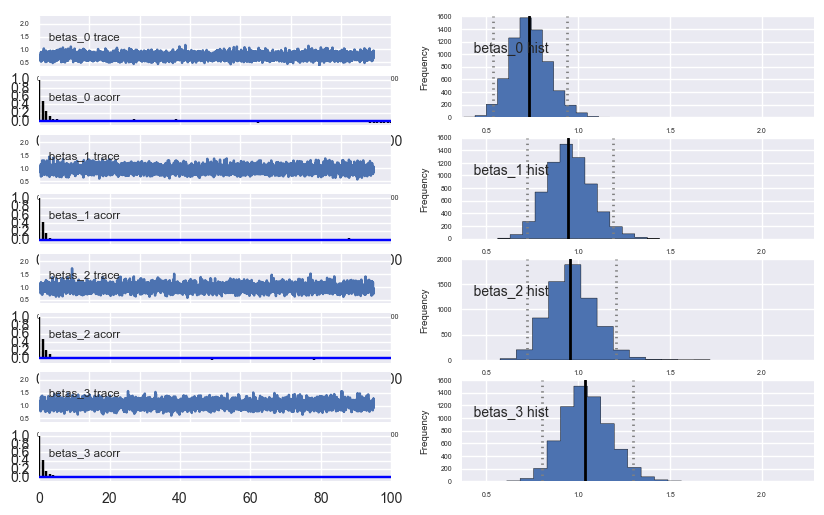

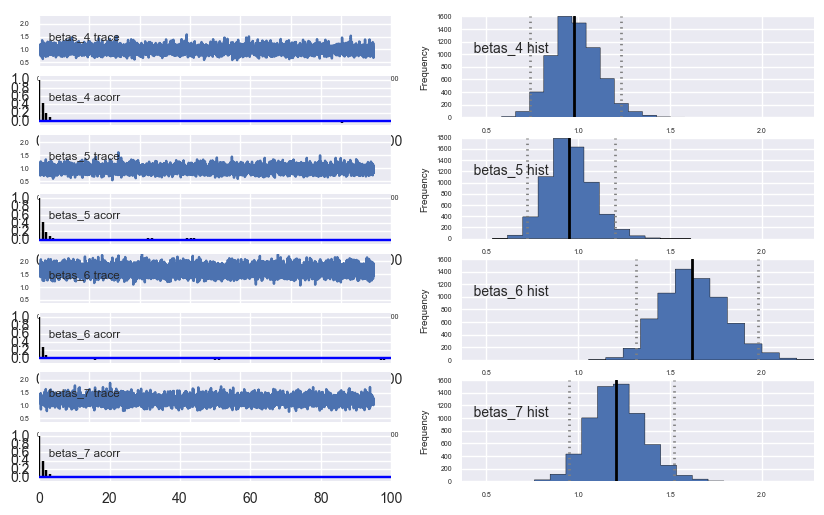

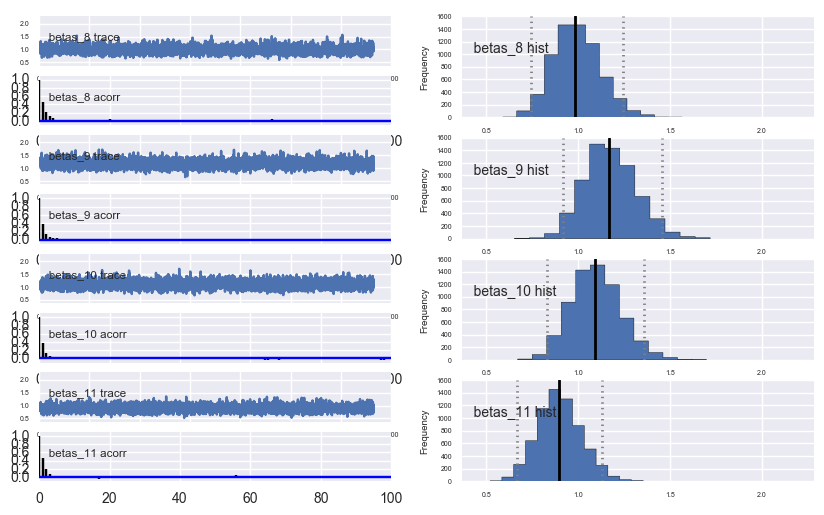

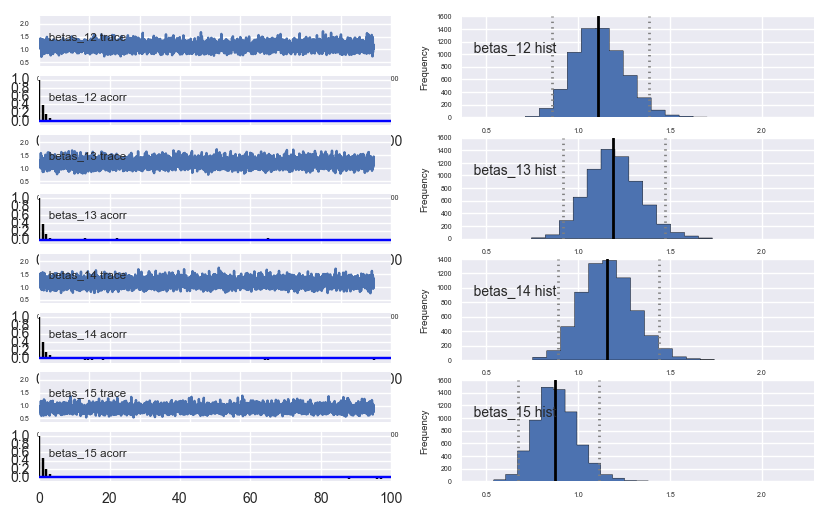

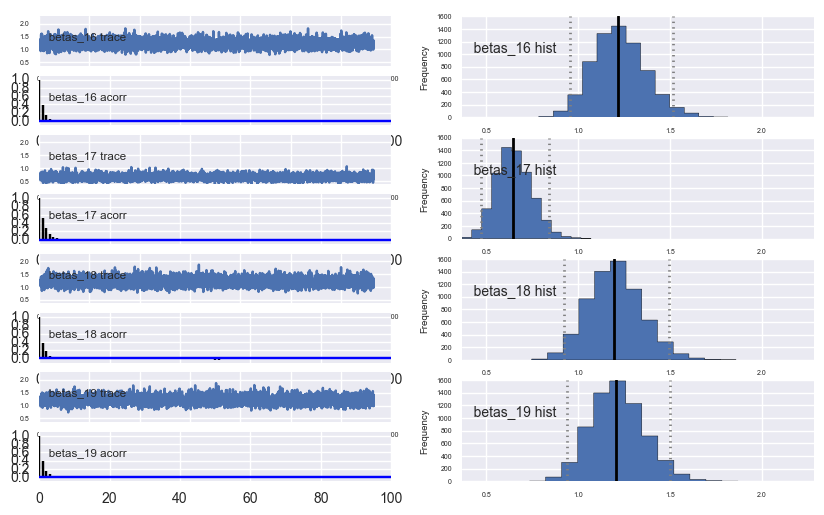

In [64]:
pymc.Matplot.plot(betas)

# Results 

In [12]:
def points(x,y):
    return [(x>y)*3+(x==y),(x<y)*3+(x==y)]

import scipy.stats as ss
df=clean_df(df)
df[['home_points','away_points']]=pd.DataFrame(np.transpose(points(df['home_score'],df['away_score'])))
total_scores=df.groupby('away')['away_points'].sum()+df.groupby('home')['home_points'].sum()
ranking=pd.DataFrame(columns=['teams','points'])
ranking['team']=total_scores.keys()
ranking['points']=total_scores.values
ranking['final_rank']=ss.rankdata(-total_scores)

def get_season_outcome(x):
    if x.final_rank<3:
        return 'champs_league'
    elif x.final_rank<6:
        return 'europa_league'
    elif x.final_rank>17: 
        return 'relegation'
    else:
        return ''

ranking['QR']=ranking.apply(get_season_outcome,axis=1)



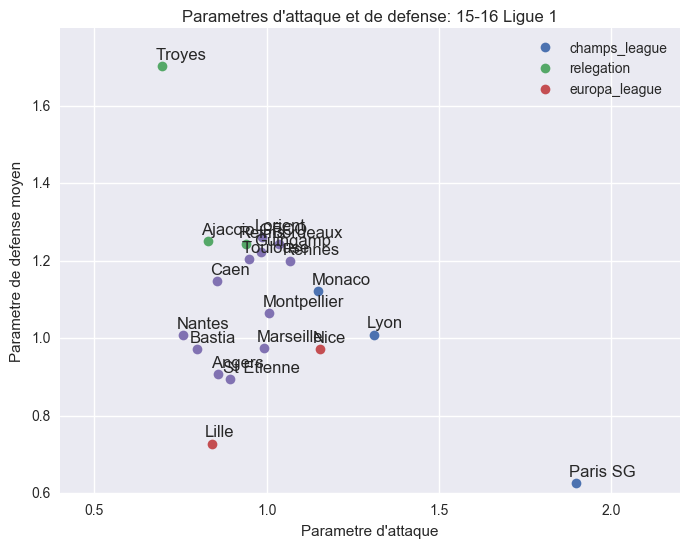

In [30]:
df_observed =ranking
df_observed.loc[df_observed.QR.isnull(), 'QR'] = ''
df_avg = pd.DataFrame({'avg_att': (mcmc_15_thin200.stats()['alphas']['mean']),
                       'avg_def': (mcmc_15_thin200.stats()['betas']['mean'])}, 
                      index=df.home.unique())
df_avg = pd.merge(df_avg, df_observed, left_index=True, right_on='team', how='left')

fig, ax = plt.subplots(figsize=(8,6))
for outcome in ['champs_league', 'relegation', 'europa_league', '']:
    ax.plot(df_avg.avg_att[df_avg.QR == outcome], 
            df_avg.avg_def[df_avg.QR == outcome], 'o', label=outcome)
    
for label, x, y in zip(df_avg.team.values, df_avg.avg_att.values, df_avg.avg_def.values):
    ax.annotate(label, xy=(x,y), xytext = (-5,5), textcoords = 'offset points')
plt.xlim(0.4,2.2)
plt.ylim(0.6,1.8)
ax.set_title("Parametres d'attaque et de defense: 15-16 Ligue 1")
ax.set_xlabel("Parametre d'attaque")
ax.set_ylabel("Parametre de defense moyen")
ax.legend()


In [27]:
rank_dic=dict(zip(ranking['team'],ranking['final_rank']))
df_teams_paras['rank']=[rank_dic[x] for x in df_teams_paras.index]


In [28]:
df_teams_paras=df_teams_paras.sort_values(by='rank')
df_teams_paras['Rang']=range(1,21)
print(df_teams_paras.round(2).drop('rank',axis=1)[['Rang',"mean_alpha","std_alpha",'mean_beta','std_beta']].to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  Rang &  mean\_alpha &  std\_alpha &  mean\_beta &  std\_beta \\
\midrule
Paris SG     &     1 &        2.09 &       0.20 &       0.62 &      0.09 \\
Lyon         &     2 &        1.40 &       0.17 &       0.95 &      0.13 \\
Monaco       &     3 &        1.19 &       0.15 &       1.06 &      0.14 \\
Nice         &     4 &        1.20 &       0.15 &       0.92 &      0.12 \\
Lille        &     5 &        0.80 &       0.12 &       0.70 &      0.10 \\
St Etienne   &     6 &        0.85 &       0.13 &       0.84 &      0.12 \\
Caen         &     7 &        0.82 &       0.13 &       1.08 &      0.14 \\
Rennes       &     8 &        1.10 &       0.15 &       1.12 &      0.14 \\
Bastia       &     9 &        0.75 &       0.12 &       0.92 &      0.12 \\
Bordeaux     &    10 &        1.05 &       0.15 &       1.17 &      0.14 \\
Angers       &    11 &        0.83 &       0.13 &       0.86 &      0.11 \\
Montpellier  &    12 &        1.02 &       0.14 &   

# Goal distribution for every game

In [30]:
#Functions useful for later
def get_pred(probas):
    i=np.argmax(probas)
    dic={0:'home',1:'draw',2:'away'}
    return(dic[i])

def get_outcome(results):
    if results['home_score'] > results['away_score']:
        return 'home' 
    elif results['home_score'] < results['away_score']:
        return 'away'
    else: 
        return 'draw'
    

In [31]:
from scipy import stats

possible_goals=np.arange(6)
def get_distributions(home_thetas,away_thetas,idx_game):
    print(idx_game)
    home_goals_pdf=np.array([stats.poisson.pmf(possible_goals,mu) 
                               for mu in home_thetas[:,idx_game]]).mean(axis=0)
    away_goals_pdf=np.array([stats.poisson.pmf(possible_goals,mu) 
                               for mu in away_thetas[:,idx_game]]).mean(axis=0)
    return (home_goals_pdf,away_goals_pdf)

def get_mean_goals(home_theta,away_theta,idx_game):
    (home_goals_pdf,away_goals_pdf)=get_distributions(home_theta,away_theta,idx_game)
    
    #Expectation of goals
    mean_home=(home_goals_pdf*possible_goals).sum()
    mean_away=(away_goals_pdf*possible_goals).sum()
    return (mean_home,mean_away) 


def distrib_to_probas(home_goals_pdf,away_goals_pdf):
    #we compute the strict cdf
    home_goals_cdf=np.array([np.sum([home_goals_pdf[:i]]) 
                                    for i in possible_goals])
    away_goals_cdf=np.array([np.sum([away_goals_pdf[:i]]) 
                                    for i in possible_goals])
    proba_home=0
    for i in np.arange(1,len(possible_goals)):
        proba_home+=home_goals_pdf[i]*away_goals_cdf[i]
        
    proba_draw=0
    for i in possible_goals:
        proba_draw+=home_goals_pdf[i]*away_goals_pdf[i]
    
    proba_away=0
    for i in np.arange(1,len(possible_goals)):
        proba_away+=away_goals_pdf[i]*home_goals_cdf[i]

    #TODO : check proba_home+proba_draw+proba_away=1
    return([proba_home,proba_draw,proba_away])


def get_outcome_probas(home_theta,away_theta,idx_game):
    (home_goals_pdf,away_goals_pdf)=get_distributions(home_theta,away_theta,idx_game)
    
    return(distrib_to_probas(home_goals_pdf,away_goals_pdf))
                    

In [60]:
df_used=clean_df(df_15[:370])
distrib=pd.DataFrame([get_distributions(mcmc_15_thin50.trace('home_theta'),mcmc.trace('away_theta'),i)
                      for i in range(len(df_used))])


In [58]:
def get_results(distrib,df_used):
    df_results = distrib.reindex(columns=['home_distrib','away_distrib','home','away','home_proba','draw_proba','away_proba'])
    df_results.index=df_used.index
    df_results[['home','away']]=np.array(df_used[['home','away']])
    df_results[['home_distrib','away_distrib']]=np.array(distrib[[0,1]])

    for i,value in enumerate(['home_proba','draw_proba','away_proba']):
        df_results[value]=df_results.apply(lambda x : distrib_to_probas(x.home_distrib,x.away_distrib)[i],axis=1)

    df_results['prediction']=df_results.apply(lambda x: get_pred([x.home_proba,x.draw_proba,x.away_proba]),axis=1)
    df_results["game_outcome"]=np.array(df_used.apply(get_outcome,axis=1))
    return df_results

In [59]:
#df_results_200=get_results(mcmc_15)
df_results_50=get_results(distrib,clean_df(df_used))

In [60]:
df_results

,home_distrib,away_distrib,home,away,home_proba,draw_proba,away_proba,prediction,game_outcome
0,"[0.500148640357, 0.340924620995, 0.12163763225...","[0.221619298849, 0.327011766185, 0.24792202394...",Lille,Paris SG,0.172801,0.256702,0.564071,away,away
1,"[0.319988589612, 0.355762338662, 0.20631749058...","[0.357235214847, 0.361298658278, 0.18893050458...",Bastia,Rennes,0.382989,0.288010,0.326032,home,home
2,"[0.231836287798, 0.330372746149, 0.24355038189...","[0.458238941502, 0.351815984586, 0.14066887908...",Marseille,Caen,0.530440,0.261994,0.201441,home,away
3,"[0.29961503702, 0.353102286847, 0.215801564232...","[0.427198729294, 0.356999979818, 0.15529513638...",Montpellier,Angers,0.443238,0.292184,0.261770,home,away
4,"[0.340897140497, 0.358208225196, 0.19653951651...","[0.384315673131, 0.36115353301, 0.17587325851,...",Nantes,Guingamp,0.380708,0.299744,0.317337,home,home
5,"[0.17671568755, 0.29766554659, 0.258906486225,...","[0.322923621662, 0.358343752117, 0.20530756450...",Nice,Monaco,0.506579,0.231368,0.247914,home,away
6,"[0.381018193643, 0.359296686239, 0.17747935103...","[0.290665451366, 0.350795336337, 0.21972403769...",Troyes,Ajaccio GFCO,0.290363,0.282163,0.423892,away,draw
7,"[0.188473779479, 0.305899156984, 0.25646252726...","[0.335293475372, 0.359425231209, 0.19940344504...",Bordeaux,Reims,0.501483,0.237204,0.249282,home,away
8,"[0.107173243965, 0.232337230495, 0.25845355016...","[0.381995110868, 0.361446895252, 0.17697108652...",Lyon,Lorient,0.630009,0.184405,0.150097,home,draw
9,"[0.331937623928, 0.358360422888, 0.20089471572...","[0.369850272488, 0.361459327851, 0.18284071359...",Toulouse,St Etienne,0.379475,0.294431,0.323644,home,home


In [61]:
df_results_50

,home_distrib,away_distrib,home,away,home_proba,draw_proba,away_proba,prediction,game_outcome
0,"[0.504592612682, 0.339092706712, 0.11984453999...","[0.221619298849, 0.327011766185, 0.24792202394...",Lille,Paris SG,0.170740,0.256554,0.566287,away,away
1,"[0.303723273829, 0.353864063619, 0.21392824088...","[0.357235214847, 0.361298658278, 0.18893050458...",Bastia,Rennes,0.397321,0.283440,0.315918,home,home
2,"[0.220568527306, 0.325668671952, 0.2478648782,...","[0.458238941502, 0.351815984586, 0.14066887908...",Marseille,Caen,0.542396,0.256042,0.194722,home,away
3,"[0.315922865691, 0.3563784267, 0.208417894758,...","[0.427198729294, 0.356999979818, 0.15529513638...",Montpellier,Angers,0.427601,0.298806,0.271266,home,away
4,"[0.309063517187, 0.355691450377, 0.21164040148...","[0.384315673131, 0.36115353301, 0.17587325851,...",Nantes,Guingamp,0.408653,0.290041,0.298538,home,home
5,"[0.188916998318, 0.306750966955, 0.25678307295...","[0.322923621662, 0.358343752117, 0.20530756450...",Nice,Monaco,0.492190,0.237363,0.258535,home,away
6,"[0.319648518251, 0.356604594166, 0.20661912261...","[0.290665451366, 0.350795336337, 0.21972403769...",Troyes,Ajaccio GFCO,0.338778,0.272171,0.384506,away,draw
7,"[0.183970219443, 0.303483544725, 0.25791199367...","[0.335293475372, 0.359425231209, 0.19940344504...",Bordeaux,Reims,0.506414,0.235350,0.245792,home,away
8,"[0.114857919253, 0.241344837133, 0.2604428855,...","[0.381995110868, 0.361446895252, 0.17697108652...",Lyon,Lorient,0.620928,0.190584,0.157200,home,draw
9,"[0.352256618755, 0.360524176079, 0.19126887486...","[0.369850272488, 0.361459327851, 0.18284071359...",Toulouse,St Etienne,0.361520,0.300405,0.336013,home,home


In [66]:
df_results[:370][['home_proba','draw_proba','away_proba']]-df_results_50[['home_proba','draw_proba','away_proba']]

,home_proba,draw_proba,away_proba
0,0.002062,0.000148,-0.002216
1,-0.014332,0.004570,0.010113
2,-0.011957,0.005952,0.006719
3,0.015636,-0.006622,-0.009497
4,-0.027946,0.009704,0.018799
5,0.014389,-0.005995,-0.010621
6,-0.048414,0.009991,0.039386
7,-0.004931,0.001854,0.003489
8,0.009082,-0.006180,-0.007102
9,0.017955,-0.005975,-0.012369


In [112]:
df_results['home_distrib'][370].reshape(8,1)

array([[ 0.27243271],
       [ 0.3446502 ],
       [ 0.22719981],
       [ 0.10396339],
       [ 0.03711103],
       [ 0.01101072],
       [ 0.00282498],
       [ 0.00064382]])

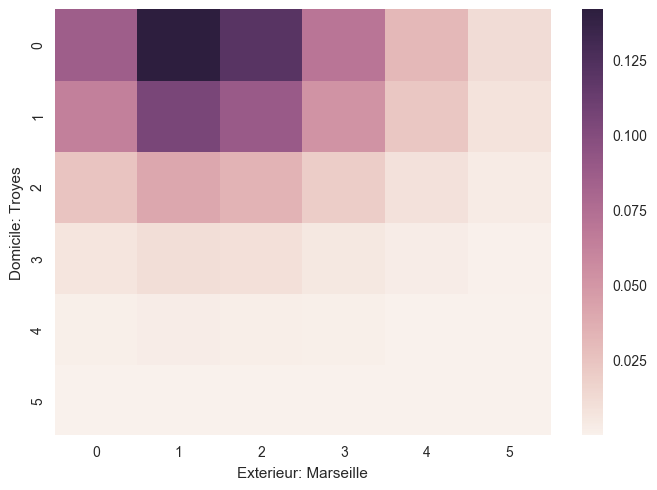

In [141]:
import seaborn as sns; sns.set()

i=379
matrix=np.dot(df_results['home_distrib'][i].reshape(6,1),df_results['away_distrib'][i].reshape(1,6))
ax = sns.heatmap(matrix)
plt.ylabel("Domicile: "+str(df_results['home'][i]))
plt.xlabel("Exterieur: "+str(df_results['away'][i]))



In [45]:
df_results.groupby(['game_outcome','prediction']).size()

game_outcome  prediction
away          away          1
              home          4
draw          away          1
              draw          1
home          away          1
              home          2
dtype: int64

In [48]:
df_results['game_outcome'].value_counts()/len(df_results)

away    0.5
home    0.3
draw    0.2
Name: game_outcome, dtype: float64

In [49]:
(df_14[['B365H','B365D','B365A']]).apply(np.argmin,axis=1).value_counts()/len(df_14)

B365H    0.755263
B365A    0.244737
dtype: float64

Prediction accuracy on training data: 48%
Benchmark: most represented outcome: 42% 

Let's have a look at the probabilities that the bookmakers have used.

In [172]:
#Induced probabilities
induced_probas=df_15[['PSH','PSD','PSA']].apply(lambda x: [1/(x[0]),1/(x[1]),1/(x[2])],axis=1)
#Sum of induced probas
print(induced_probas.sum(axis=1).head())
#Mean of sum of induced probas
print('\n')
print(induced_probas.sum(axis=1).head().mean())

0    1.021213
1    1.025962
2    1.022656
3    1.024016
4    1.025465
dtype: float64


1.02386235521


In [173]:
#The probas seem to always sum up to 1.02.

In [174]:
induced_probas.tail(10)


,PSH,PSD,PSA
370,0.221239,0.271739,0.531915
371,0.421941,0.280112,0.323625
372,0.217865,0.260417,0.546448
373,0.315457,0.280899,0.429185
374,0.699301,0.195695,0.132626
375,0.781250,0.159236,0.087260
376,0.292398,0.247525,0.485437
377,0.534759,0.265252,0.225225
378,0.408163,0.299401,0.318471
379,0.209205,0.222222,0.591716


In [227]:
induced_probas.columns=["home_proba","draw_proba","away_proba"]
results_probas=df_results[["home_proba","draw_proba","away_proba"]]
#induced_probas/results_probas
dummies=pd.get_dummies(df_results['game_outcome'])
dummies.columns=["away_proba","draw_proba","home_proba"]

gain=results_probas/induced_probas-1

In [239]:
r=0.2
isbet=gain>r
cotes=1/induced_probas
isbet*cotes


,home_proba,draw_proba,away_proba
0,0.00,0.00,0.00
1,0.00,0.00,0.00
2,0.00,0.00,6.59
3,0.00,0.00,5.53
4,0.00,0.00,4.01
5,4.14,0.00,0.00
6,0.00,0.00,4.43
7,0.00,0.00,5.80
8,0.00,0.00,0.00
9,0.00,0.00,0.00


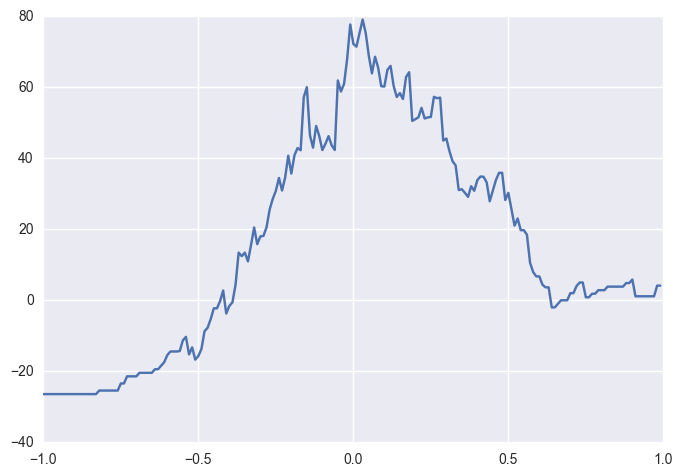

In [251]:
def gain_total(r):
    isbet=gain>r
    somme=(isbet*dummies*cotes - isbet).sum().sum()
    return somme
r_values=np.arange(-1,1,0.01)
gains=[gain_total(r) for r in r_values]
plt.plot(r_values,gains)
plt.show()

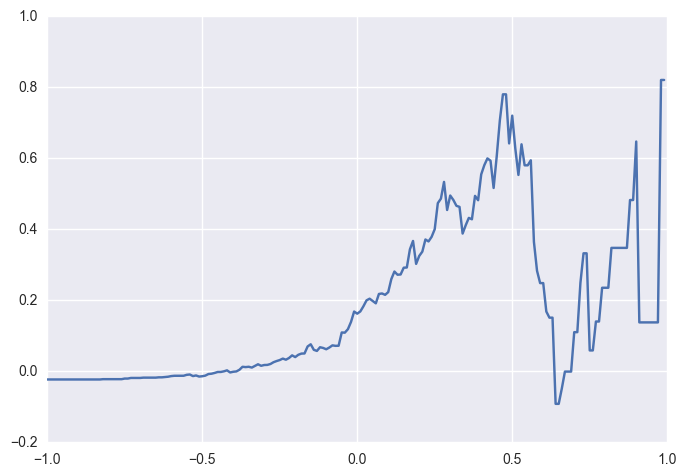

In [250]:
def gain_moyen(r):
    isbet=gain>r
    mean=(isbet*dummies*cotes - isbet).sum().sum()/isbet.sum().sum()
    return mean
means=[gain_moyen(r) for r in r_values]
plt.plot(r_values,means)
plt.show()

# Probabilities

In [260]:
print(df_results.tail(10)[['home','away','home_proba','draw_proba','away_proba']].round(2).to_latex())

\begin{tabular}{lllrrr}
\toprule
{} &        home &          away &  home\_proba &  draw\_proba &  away\_proba \\
\midrule
370 &      Angers &      Toulouse &        0.48 &        0.28 &        0.23 \\
371 &        Caen &      Bordeaux &        0.40 &        0.26 &        0.33 \\
372 &    Guingamp &          Nice &        0.31 &        0.25 &        0.42 \\
373 &     Lorient &  Ajaccio GFCO &        0.52 &        0.24 &        0.23 \\
374 &      Monaco &   Montpellier &        0.49 &        0.24 &        0.26 \\
375 &    Paris SG &        Nantes &        0.79 &        0.11 &        0.03 \\
376 &       Reims &          Lyon &        0.27 &        0.23 &        0.48 \\
377 &      Rennes &        Bastia &        0.48 &        0.27 &        0.24 \\
378 &  St Etienne &         Lille &        0.34 &        0.38 &        0.29 \\
379 &      Troyes &     Marseille &        0.17 &        0.23 &        0.59 \\
\bottomrule
\end{tabular}

